In [3]:
import io
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)  # اگر لازم بود force_remount=True کنید
DATA_DIR = "/content/drive/MyDrive/rnn/data/names"
os.makedirs(DATA_DIR, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import io
import os
import glob
import unicodedata
import string
import random
import torch

# حروف مجاز
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

def unicode_to_ascii(s: str) -> str:
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in ALL_LETTERS
    )

def load_data(data_dir: str):
    """
    فایل‌های .txt داخل data_dir را می‌خواند و برمی‌گرداند:
    - category_lines: دیکشنری {نام_دسته: لیست_اسامی}
    - all_categories: لیست نام دسته‌ها (زبان‌ها)
    """
    if not os.path.isdir(data_dir):
        raise FileNotFoundError(f"Folder not found: {data_dir}")

    files = glob.glob(os.path.join(data_dir, "*.txt"))
    if len(files) == 0:
        raise FileNotFoundError(f"No .txt files found in: {data_dir}")

    category_lines = {}
    all_categories = []

    for filename in sorted(files):
        category = os.path.splitext(os.path.basename(filename))[0]
        with io.open(filename, encoding='utf-8') as f:
            lines = f.read().strip().split("\n")
        lines = [unicode_to_ascii(line) for line in lines if line.strip()]
        if len(lines) == 0:
            # اگر فایلی خالی بود، ازش عبور کنید
            continue
        category_lines[category] = lines
        all_categories.append(category)

    if len(all_categories) == 0:
        raise RuntimeError("Found files but no valid lines were parsed.")
    return category_lines, all_categories

def letter_to_index(letter: str) -> int:
    return ALL_LETTERS.find(letter)

def letter_to_tensor(letter: str) -> torch.Tensor:
    # <1 x N_LETTERS>
    t = torch.zeros(1, N_LETTERS)
    idx = letter_to_index(letter)
    if idx >= 0:
        t[0, idx] = 1.0
    return t

def line_to_tensor(line: str) -> torch.Tensor:
    # <line_length x 1 x N_LETTERS>
    t = torch.zeros(len(line), 1, N_LETTERS)
    for i, ch in enumerate(line):
        idx = letter_to_index(ch)
        if idx >= 0:
            t[i, 0, idx] = 1.0
    return t

def random_training_example(category_lines, all_categories):
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor


In [5]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        concat_size = input_size + hidden_size
        self.i2h = nn.Linear(concat_size, hidden_size)   # [x_t, h_{t-1}] -> h_t
        self.i2o = nn.Linear(concat_size, output_size)   # [x_t, h_{t-1}] -> y_t (logits)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor):
        # input_tensor: (1, input_size)
        # hidden_tensor: (1, hidden_size)
        if input_tensor.dim() == 1:
            input_tensor = input_tensor.unsqueeze(0)
        if hidden_tensor.dim() == 1:
            hidden_tensor = hidden_tensor.unsqueeze(0)

        combined = torch.cat((input_tensor, hidden_tensor), dim=1)
        hidden = torch.tanh(self.i2h(combined))
        output_logits = self.i2o(combined)
        output = self.log_softmax(output_logits)  # (1, output_size) log-probs
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
category_lines, all_categories = load_data(DATA_DIR)

n_categories = len(all_categories)
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)

# whole sequence/name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

Greek


5000 5.0% loss=0.5351 | Mariani → Italian CORRECT
10000 10.0% loss=2.0128 | Sappe → French WRONG (Czech)
15000 15.0% loss=1.0220 | Cho → Korean CORRECT
20000 20.0% loss=3.1709 | Mendel → Czech WRONG (German)
25000 25.0% loss=0.8030 | Zitka → Czech CORRECT
30000 30.0% loss=7.9266 | Boutros → Greek WRONG (Arabic)
35000 35.0% loss=0.0283 | Kagawa → Japanese CORRECT
40000 40.0% loss=0.3740 | Song → Korean CORRECT
45000 45.0% loss=0.0402 | Zha → Chinese CORRECT
50000 50.0% loss=0.0051 | Mckenzie → Scottish CORRECT
55000 55.0% loss=0.5117 | Bailey → English CORRECT
60000 60.0% loss=3.6542 | Hung → Chinese WRONG (Korean)
65000 65.0% loss=0.0056 | Islakaev → Russian CORRECT
70000 70.0% loss=2.4960 | Daviau → Japanese WRONG (French)
75000 75.0% loss=0.1486 | Cathain → Irish CORRECT
80000 80.0% loss=2.1733 | Peake → German WRONG (English)
85000 85.0% loss=0.6569 | Hofer → German CORRECT
90000 90.0% loss=4.6030 | Gerstle → Portuguese WRONG (German)
95000 95.0% loss=5.7556 | Daugulis → Greek WRONG

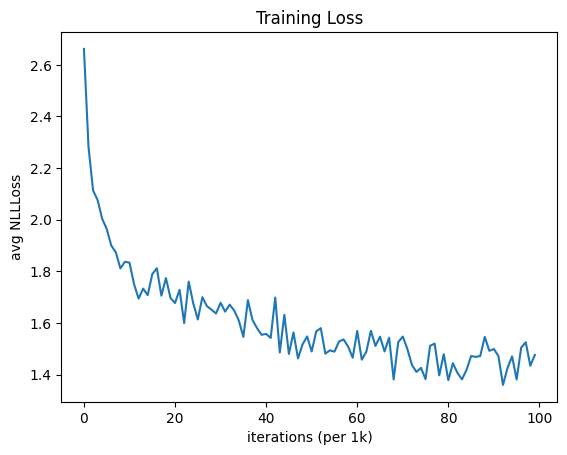

In [7]:
import matplotlib.pyplot as plt

# --- Loss & Optimizer ---
criterion = torch.nn.NLLLoss()          # مناسب برای log-probabilities
learning_rate = 5e-3                    # شروع محافظه‌کارانه؛ اگر کند بود 1e-2 کنید
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

# --- Single training step ---
def train(line_tensor: torch.Tensor, category_tensor: torch.Tensor):
    rnn.train()
    hidden = rnn.init_hidden()

    optimizer.zero_grad()

    # عبور ترتیبی کاراکترها از شبکه
    for t in range(line_tensor.size(0)):
        # line_tensor[t] شکلش (1, N_LETTERS) است
        output, hidden = rnn(line_tensor[t], hidden)

    # محاسبه خطا روی خروجی آخر توالی
    loss = criterion(output, category_tensor)
    loss.backward()

    # (اختیاری) جلوگیری از انفجار گرادیان
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=5.0)

    optimizer.step()
    return output, loss.item()

# --- Training loop ---
current_loss = 0.0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000

for i in range(n_iters):
    category, line, cat_tensor, line_tensor = random_training_example(category_lines, all_categories)

    output, loss = train(line_tensor, cat_tensor)
    current_loss += loss

    if (i + 1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0.0

    if (i + 1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100:.1f}% loss={loss:.4f} | {line} → {guess} {correct}")

plt.figure()
plt.plot(all_losses)
plt.xlabel("iterations (per 1k)")
plt.ylabel("avg NLLLoss")
plt.title("Training Loss")
plt.show()


In [8]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)

        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        guess = category_from_output(output)
        print(guess)
while True:
    sentence = input("Input:")
    if sentence == "quit":
        break

    predict(sentence)


Input:jon

> jon
Polish
Input:quite

> quite
French
Input:quit
